In [101]:
# Supplemental Packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(rc={"figure.figsize":(10, 10)}) #width=3, #height=4
sns.set_theme(style="whitegrid", palette="Paired")
from scipy import stats
import ipywidgets as widgets
from scipy.stats import chi2_contingency
from scipy.stats.contingency import crosstab
from itertools import combinations
import itertools
from scipy.stats.contingency import association

# Feature Engineering
import featuretools as ft

# Imputation
from sklearn.impute import SimpleImputer

# Anomaly Detection
from sklearn.ensemble import IsolationForest

# Decision Tree, Random Forest Regressors
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.tree import export_graphviz
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor


# Error Metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import explained_variance_score
from sklearn.metrics import max_error

# pip install --upgrade scipy
# pip list --outdated

## Data Cleaning and Set up

In [2]:
# import data 
data = pd.read_csv('h209.csv')
h201 = pd.read_csv('h201.csv')
data_2017 = h201[h201['PANEL'] == 21]

In [3]:
h201_P21 = h201[h201['PANEL'] == 21]

In [246]:
def clean2017(df = None):
    
    '''
    
    Data Structure:
    ----------------
    * This dataset contains ~1500 variables, and information with regards to 30,461 persons who 
      participated in the MEPS survey during 2018
    * These 30,461 persons were part of the two MEPS panels form whom data were collected.
    * Rounds 3,4,5 of Panel 22, and Rounds 1,2,3 of Panel 23
    * Data contains variables on geography, demographics, income, healthstatus, access to care, employment
      insurance, and many more
      
    '''
    
    # Filter down to the reference person ONLY summing characteristics 
    
    df = df[(df['FAMWT17F'] > 0)] # Family weight > 0
    df['DUIDFAMY'] = (df['DUID'].astype('str')) + df['FAMIDYR'] # concatenate to create subset of families
    
    #=================================================================================================================
    # Replacing, dropping, and imputing odd codes in categorical features
    #=================================================================================================================
    
    # Data frame to merge
    socioeconomic = df[['DUID',
                        'DUIDFAMY',
                        'FAMIDYR',
                        'FAMRFPYR', # reference person indicator
                        'INSCOP17', # Whether an individual was inscope
                        'PANEL',    # Panel Number
                        'REGION31', # region panel 31
                        'REGION42', # region panel 42
                        'REGION53', # region panel 53
                        'PROBPY42', # trouble paying off bills
                        'CRFMPY42', # paying bills overtime
                        'FAMINC17', # unable to be paid at all
                        'POVLEV17', # POVLEV18 = CPS Family Income / Poverty Line
                        'MCDHMO31', # MDC Indicator
                        'MCDHMO42', # MDC Indicator
                        'MCDHMO17', # MCD Indicator
                        'ACTLIM31', # Any limitation to work/housework,
                        'COGLIM31', # Cognitive limitations (person level)
                        'DFHEAR42', # Indicates whether a person has serious difficulty hearing
                        'DFSEE42', # Indicates whether a person has difficulty seeing
                        'ADGENH42', # General health
                        #'AFRDPM42', # could not affor perscription medications
                        'ACCELI42', # Could not afford medical care 
                        #'AFRDDN42', # Could not afford dental care 
                        'FAMSZEYR'
                       ]]
    
    
    # Replacing codes with another value (2 = No) or Removing them from the sample (-7)
    # (-1) is inapplicable
    socioeconomic = socioeconomic.replace({'ACTLIM31' : -1,
                         'COGLIM31' : -1,
                         'DFHEAR42' : -1,
                         'DFSEE42' : -1,
                         'ADGENH42' : -1,
                         #'AFRDPM42' : -1,
                         'AFRDCA42' : -1,
                         #'AFRDDN42' : -1
                        }, 2) 
    
    # (-8) is Do not Know
    socioeconomic = socioeconomic.replace({'PROBPY42' : -8,
                         'CRFMPY42' : -8,
                         'FSAGT31' : -8,
                         'ACTLIM31' : -8,
                         'COGLIM31' : -8,
                         'DFHEAR42' : -8,
                         'COGLIM31' : -8,
                         'DFSEE42' : -8,
                         #'AFRDDN42' : -8
                        }, 2)
    
    socioeconomic['ACTLIM31'] = socioeconomic['ACTLIM31'].fillna(0)
    
    socioeconomic = socioeconomic[socioeconomic.isin([-7]) == False] # drop any rows containing -7 (refused)
    
    # IMPUTATION
    # need to impute the -15 code
    socioeconomic = socioeconomic.replace({'ADGENH42' : -15}, np.nan)
    imp_mstfreq = SimpleImputer(missing_values=np.nan, strategy = 'most_frequent')
    # reshape as a column vector using reshape (-1,1)
    socioeconomic['ADGENH42'] = imp_mstfreq.fit_transform(socioeconomic['ADGENH42'].values.reshape(-1,1))
    
    # FEATURE ENGINEERING
    # for variables where it is an individual, sum all the Yes's and No's then subtract family size
    additions = socioeconomic.groupby('DUIDFAMY').agg({
                                                       'DFHEAR42' : 'min', 
                                                       'DFSEE42' : 'min',
                                                       'ADGENH42' : 'sum'
                                                      }).reset_index()
    
    socioeconomic = socioeconomic.drop(columns = ['DFHEAR42', 'DFSEE42', 'ADGENH42'])
    
    #=================================================================================================================
    # Summing all expenditure codes across all family members
    #=================================================================================================================
    
    # Use the reference person FAMRFPYR to characterize the family unit
    # For numeric variables we are taking the sum of all family members
    expenditures = df.groupby('DUIDFAMY').agg({'RXMCD17' : 'sum',
                                             'RXSLF17' : 'sum',
                                             'OPTMCD17' : 'sum',
                                             'OPTSLF17' : 'sum',
                                             'ERTMCD17' : 'sum',
                                             'ERTSLF17' : 'sum',
                                             'IPTMCD17' : 'sum',
                                             'IPTSLF17' : 'sum',
                                             'DVTMCD17' : 'sum',
                                             'DVTSLF17' : 'sum',
                                             'HHAMCD17' : 'sum',
                                             'HHNSLF17' : 'sum',
                                             'VISMCD17' : 'sum',
                                             'VISSLF17' : 'sum',
                                             'OTHMCD17' : 'sum', 
                                             'OTHSLF17' : 'sum',
                                             'TTLP17X' : 'sum', # Persons Income
                                    }).reset_index()
    
    ###============================================================================================================
    ### ALL VARIABLES NEED TO BY REPLACED (IF CODES ARE INCORRECT) AND/OR IMPUTED BEFORE CALCULATIONS ARE PERFORMED
    ### AND THE JOIN OCCURS
    ###============================================================================================================
    
    # Performa join on the socioeconomic variables and expenditure data
    join = pd.merge(pd.merge(socioeconomic,
                    expenditures,
                    how = "left",
                    on = 'DUIDFAMY',
                    suffixes = ("_ECON", "_EXP")
                            ),
                    additions,
                    on = 'DUIDFAMY'
                   )
    
    # Filter data set down to reference person
    join = join[(join['FAMRFPYR'] == 1)]
    join = join[((join['MCDHMO31'] == 1) | (join['MCDHMO31'] == 2)) &
                ((join['MCDHMO42'] == 1) | (join['MCDHMO42'] == 2)) &
                ((join['MCDHMO17'] == 1) | (join['MCDHMO17'] == 2))
               ]
    
    join['ADGENH42_eng'] = (join['ADGENH42'] / join['FAMSZEYR']).round()
    
    join = join.drop(columns=['MCDHMO31',
                              'MCDHMO42',
                              'MCDHMO17',
                              'DUID',
                              'INSCOP17',
                              'FAMIDYR',
                              'DUIDFAMY', # keep for feature tools
                              'PANEL',
                              'FAMRFPYR',
                              'FAMINC17',
                              'ACCELI42',
                              'ACTLIM31',
                              'ADGENH42',
                              'FAMSZEYR',
                              'REGION53',
                              'REGION42'
                             ]
                    ).reset_index(drop=True)
    
    return expenditures, socioeconomic, join, additions

In [247]:
expenditures17, socioeconomic17, join17, additions17 = clean2017(df = data_2017)

In [248]:
def cleanv2(df = None):
    
    '''
    
    Data Structure:
    ----------------
    * This dataset contains ~1500 variables, and information with regards to 30,461 persons who 
      participated in the MEPS survey during 2018
    * These 30,461 persons were part of the two MEPS panels form whom data were collected.
    * Rounds 3,4,5 of Panel 22, and Rounds 1,2,3 of Panel 23
    * Data contains variables on geography, demographics, income, healthstatus, access to care, employment
      insurance, and many more
      
    '''
    
    # Filter down to the reference person ONLY summing characteristics 
    
    df = df[(df['FAMWT18F'] > 0)] # Family weight > 0
    df['DUIDFAMY'] = (df['DUID'].astype('str')) + df['FAMIDYR'] # concatenate to create subset of families
    
    #=================================================================================================================
    # Replacing, dropping, and imputing odd codes in categorical features
    #=================================================================================================================
    
    # Data frame to merge
    socioeconomic = df[['DUID',
                        'DUIDFAMY',
                        'FAMIDYR',
                        'FAMRFPYR', # reference person indicator
                        'INSCOP18', # Whether an individual was inscope
                        'PANEL',    # Panel Number
                        'REGION31', # region panel 31
                        'REGION42', # region panel 42
                        'REGION53', # region panel 53
                        'PROBPY42', # trouble paying off bills
                        'CRFMPY42', # paying bills overtime
                        'FAMINC18', # unable to be paid at all
                        'POVLEV18', # POVLEV18 = CPS Family Income / Poverty Line
                        'MCDHMO31', # MDC Indicator
                        'MCDHMO42', # MDC Indicator
                        'MCDHMO18', # MCD Indicator
                        'ACTLIM31', # Any limitation to work/housework,
                        'COGLIM31', # Cognitive limitations (person level)
                        'DFHEAR42', # Indicates whether a person has serious difficulty hearing
                        'DFSEE42', # Indicates whether a person has difficulty seeing
                        'ADGENH42', # General health
                        'AFRDPM42', # could not affor perscription medications
                        'ACCELI42', # Could not afford medical care 
                        'AFRDDN42', # Could not afford dental care 
                        'FAMSZEYR'
                       ]]
    
    
    # Replacing codes with another value (2 = No) or Removing them from the sample (-7)
    # (-1) is inapplicable
    socioeconomic = socioeconomic.replace({'ACTLIM31' : -1,
                         'COGLIM31' : -1,
                         'DFHEAR42' : -1,
                         'DFSEE42' : -1,
                         'ADGENH42' : -1,
                         'AFRDPM42' : -1,
                         'AFRDCA42' : -1,
                         'AFRDDN42' : -1
                        }, 2) 
    
    # (-8) is Do not Know
    socioeconomic = socioeconomic.replace({'PROBPY42' : -8,
                         'CRFMPY42' : -8,
                         'FSAGT31' : -8,
                         'ACTLIM31' : -8,
                         'COGLIM31' : -8,
                         'DFHEAR42' : -8,
                         'COGLIM31' : -8,
                         'DFSEE42' : -8,
                         'AFRDDN42' : -8
                        }, 2)
    
    socioeconomic['ACTLIM31'] = socioeconomic['ACTLIM31'].fillna(0)
    
    socioeconomic = socioeconomic[socioeconomic.isin([-7]) == False] # drop any rows containing -7 (refused)
    
    # IMPUTATION
    # need to impute the -15 code
    socioeconomic = socioeconomic.replace({'ADGENH42' : -15}, np.nan)
    imp_mstfreq = SimpleImputer(missing_values=np.nan, strategy = 'most_frequent')
    # reshape as a column vector using reshape (-1,1)
    socioeconomic['ADGENH42'] = imp_mstfreq.fit_transform(socioeconomic['ADGENH42'].values.reshape(-1,1))
    
    # FEATURE ENGINEERING
    # for variables where it is an individual, sum all the Yes's and No's then subtract family size
    additions = socioeconomic.groupby('DUIDFAMY').agg({
                                                       'DFHEAR42' : 'min', 
                                                       'DFSEE42' : 'min',
                                                       'ADGENH42' : 'sum'
                                                      }).reset_index()
    
    socioeconomic = socioeconomic.drop(columns = ['DFHEAR42', 'DFSEE42', 'ADGENH42'])
    
    #=================================================================================================================
    # Summing all expenditure codes across all family members
    #=================================================================================================================
    
    # Use the reference person FAMRFPYR to characterize the family unit
    # For numeric variables we are taking the sum of all family members
    expenditures = df.groupby('DUIDFAMY').agg({'RXMCD18' : 'sum',
                                             'RXSLF18' : 'sum',
                                             'OPTMCD18' : 'sum',
                                             'OPTSLF18' : 'sum',
                                             'ERTMCD18' : 'sum',
                                             'ERTSLF18' : 'sum',
                                             'IPTMCD18' : 'sum',
                                             'IPTSLF18' : 'sum',
                                             'DVTMCD18' : 'sum',
                                             'DVTSLF18' : 'sum',
                                             'HHAMCD18' : 'sum',
                                             'HHNSLF18' : 'sum',
                                             'VISMCD18' : 'sum',
                                             'VISSLF18' : 'sum',
                                             'OTHMCD18' : 'sum', 
                                             'OTHSLF18' : 'sum',
                                             'TTLP18X' : 'sum', # Persons Income
                                    }).reset_index()
    
    ###============================================================================================================
    ### ALL VARIABLES NEED TO BY REPLACED (IF CODES ARE INCORRECT) AND/OR IMPUTED BEFORE CALCULATIONS ARE PERFORMED
    ### AND THE JOIN OCCURS
    ###============================================================================================================
    
    # Performa join on the socioeconomic variables and expenditure data
    join = pd.merge(pd.merge(socioeconomic,
                    expenditures,
                    how = "left",
                    on = 'DUIDFAMY',
                    suffixes = ("_ECON", "_EXP")
                            ),
                    additions,
                    on = 'DUIDFAMY'
                   )
    
    # Filter data set down to reference person
    join = join[(join['FAMRFPYR'] == 1)]
    join = join[((join['MCDHMO31'] == 1) | (join['MCDHMO31'] == 2)) &
                ((join['MCDHMO42'] == 1) | (join['MCDHMO42'] == 2)) &
                ((join['MCDHMO18'] == 1) | (join['MCDHMO18'] == 2))
               ]
    
    join['ADGENH42_eng'] = (join['ADGENH42'] / join['FAMSZEYR']).round()
    
    join = join.drop(columns=['MCDHMO31',
                              'MCDHMO42',
                              'MCDHMO18',
                              'DUID',
                              'INSCOP18',
                              'FAMIDYR',
                              'DUIDFAMY', # keep for feature tools
                              'PANEL',
                              'FAMRFPYR',
                              'FAMINC18',
                              'ACCELI42',
                              'ACTLIM31',
                              'ADGENH42',
                              'FAMSZEYR',
                              'REGION53',
                              'REGION42'
                             ]
                    ).reset_index(drop=True)
    
    return expenditures, socioeconomic, join, additions

In [249]:
expenditures, socioeconomic, join, additions = cleanv2(df = data)

In [250]:
# Only select a subset of variables
EXP = join[['POVLEV18',
            'RXMCD18',
            'RXSLF18',
            'OPTMCD18',
            'OPTSLF18',
            'ERTMCD18',
            'ERTSLF18',
            'IPTMCD18',
            'IPTSLF18',
            'DVTMCD18',
            'DVTSLF18',
            'HHAMCD18',
            'HHNSLF18',
            'VISMCD18',
            'VISSLF18',
            'OTHMCD18',
            'OTHSLF18',
            'TTLP18X']]

SOCIO = join.drop(columns = EXP.columns)

SOCIO[SOCIO.columns] = SOCIO[SOCIO.columns].astype('category')

TEST = SOCIO.drop(columns = ['REGION31', 'PROBPY42', 'CRFMPY42', 'AFRDPM42'])

In [363]:
SOCIO.columns

Index(['REGION31', 'PROBPY42', 'CRFMPY42', 'COGLIM31', 'AFRDPM42', 'AFRDDN42',
       'DFHEAR42', 'DFSEE42', 'ADGENH42_eng', 'AMLY_SCORE'],
      dtype='object')

Text(0.5, 1.0, 'HHAMCD18')

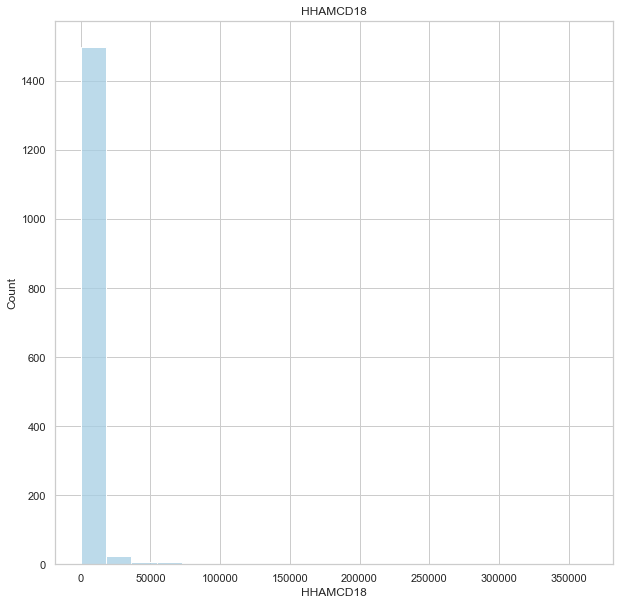

In [308]:
sns.histplot(data = EXP, x = "HHAMCD18", bins = 20)
plt.title("HHAMCD18")

In [342]:
# Only select a subset of variables
EXP17 = join17[['POVLEV17',
            'RXMCD17',
            'RXSLF17',
            'OPTMCD17',
            'OPTSLF17',
            'ERTMCD17',
            'ERTSLF17',
            'IPTMCD17',
            'IPTSLF17',
            'DVTMCD17',
            'DVTSLF17',
            'HHAMCD17',
            'HHNSLF17',
            'VISMCD17',
            'VISSLF17',
            'OTHMCD17',
            'OTHSLF17',
            'TTLP17X']]

EXP17 = EXP17.rename(columns={"POVLEV17" : "POVLEV18", 
                             'RXMCD17' : 'RXMCD18',
                             'RXSLF17' : 'RXSLF18',
                             'OPTMCD17': 'OPTMCD18',
                             'OPTSLF17' : 'OPTSLF18',
                             'ERTMCD17' : 'ERTMCD18',
                             'ERTSLF17' : 'ERTSLF18',
                             'IPTMCD17' : 'IPTMCD18',
                             'IPTSLF17' : 'IPTSLF18',
                             'DVTMCD17' : 'DVTMCD18',
                             'DVTSLF17' : 'DVTSLF18',
                             'HHAMCD17' : 'HHAMCD18',
                             'HHNSLF17' : 'HHNSLF18',
                             'VISMCD17' : 'VISMCD18',
                             'VISSLF17' : 'VISSLF18',
                             'OTHMCD17' : 'OTHMCD18',
                             'OTHSLF17' : 'OTHSLF18',
                             'TTLP17X'  : 'TTLP18X'
                             })

#SOCIO17 = join17.drop(columns = EXP17.columns)

SOCIO17[SOCIO17.columns] = SOCIO17[SOCIO17.columns].astype('category')

TEST17 = SOCIO17.drop(columns = ['REGION31', 'PROBPY42', 'CRFMPY42'])

In [275]:
SOCIO.columns

Index(['REGION31', 'PROBPY42', 'CRFMPY42', 'COGLIM31', 'AFRDPM42', 'AFRDDN42',
       'DFHEAR42', 'DFSEE42', 'ADGENH42_eng'],
      dtype='object')

In [254]:
EXP17.columns

Index(['POVLEV18', 'RXMCD18', 'RXSLF18', 'OPTMCD18', 'OPTSLF18', 'ERTMCD18',
       'ERTSLF18', 'IPTMCD18', 'IPTSLF18', 'DVTMCD18', 'DVTSLF18', 'HHAMCD18',
       'HHNSLF18', 'VISMCD18', 'VISSLF18', 'OTHMCD18', 'OTHSLF18', 'TTLP18X'],
      dtype='object')

In [255]:
EXP.columns

Index(['POVLEV18', 'RXMCD18', 'RXSLF18', 'OPTMCD18', 'OPTSLF18', 'ERTMCD18',
       'ERTSLF18', 'IPTMCD18', 'IPTSLF18', 'DVTMCD18', 'DVTSLF18', 'HHAMCD18',
       'HHNSLF18', 'VISMCD18', 'VISSLF18', 'OTHMCD18', 'OTHSLF18', 'TTLP18X'],
      dtype='object')

In [260]:
EXP1718 = pd.concat([EXP, EXP17]).reset_index(inplace = False).drop(columns=['index'])

In [261]:
EXP1718.columns

Index(['POVLEV18', 'RXMCD18', 'RXSLF18', 'OPTMCD18', 'OPTSLF18', 'ERTMCD18',
       'ERTSLF18', 'IPTMCD18', 'IPTSLF18', 'DVTMCD18', 'DVTSLF18', 'HHAMCD18',
       'HHNSLF18', 'VISMCD18', 'VISSLF18', 'OTHMCD18', 'OTHSLF18', 'TTLP18X'],
      dtype='object')

In [93]:
def chisquared(data):
    
    df = pd.DataFrame(columns=('VAR1', 'VAR2', 'Chi-Squared', 'P-value', 'Dof'))
    
    # Create empty lists to append to pandas data frame
    var1 = list()
    var2 = list()
    chi = list()
    p = list()
    dof = list()
    
    # Find all combinations of the categorical columns
    combos = list(itertools.combinations(list(SOCIO.columns), 2))
    
    for c in range(0,len(combos)):
        (avals, xvals), count = crosstab(data[str(combos[c][0])], data[str(combos[c][1])])
        values = chi2_contingency(count)
        var1.append(combos[c][0])
        var2.append(combos[c][1])
        chi.append(values[0])
        p.append(values[1])
        dof.append(values[2])
        
    df = pd.DataFrame({'VAR1' : var1, 'VAR2' : var2, 'Chi-Squared' : chi, 'P-value' : p, 'Dof' : dof})
        
    return df

In [128]:
def cramersv(data):
    
    # Create empty lists to append to pandas data frame
    var1 = list()
    var2 = list()
    cramers = list()
    
    # Find all combinations of the categorical columns
    combos = list(itertools.combinations(list(SOCIO.columns), 2))
    
    for c in range(0,len(combos)):
        (avals, xvals), count = crosstab(data[str(combos[c][0])], data[str(combos[c][1])])
        cv = association(count, method = "cramer")
        var1.append(combos[c][0])
        var2.append(combos[c][1])
        cramers.append(cv)
        
    df = pd.DataFrame({'VAR1' : var1, 'VAR2' : var2, 'CramerV' : cramers})
    
    return df

In [134]:
cv = cramersv(data = SOCIO)
chi = chisquared(data = SOCIO)
chi['CramersV'] = cv['CramerV']
#chi.to_csv('chi&cramers.csv', index = False)

## Isolation Forest Model

In [374]:
iforest = IsolationForest(n_estimators = 150,
                          contamination = 0.1,
                          bootstrap = False,
                          n_jobs = None,
                          random_state = None,
                          verbose = 1, 
                          warm_start = False).fit(join)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


In [375]:
anomalies = iforest.decision_function(join)

In [389]:
def amlyscatter(anomalies = None): 
    
    df = pd.DataFrame(anomalies, columns = ['AMLY']).reset_index()
    
    fig, ax = plt.subplots()
    ax.grid(False)
    
    sns.scatterplot(data = df, x = 'index', y = 'AMLY', hue = 'AMLY', palette = "magma")
    plt.axhline(y=0, color = 'black', alpha = 0.35)
    plt.title("Anomaly Scores derived from Isolation Forest (EXP + CAT)")
    plt.ylabel("Anomaly Score")
    plt.xlabel("Observation Index")

In [390]:
join.columns

Index(['REGION31', 'PROBPY42', 'CRFMPY42', 'POVLEV18', 'COGLIM31', 'AFRDPM42',
       'AFRDDN42', 'RXMCD18', 'RXSLF18', 'OPTMCD18', 'OPTSLF18', 'ERTMCD18',
       'ERTSLF18', 'IPTMCD18', 'IPTSLF18', 'DVTMCD18', 'DVTSLF18', 'HHAMCD18',
       'HHNSLF18', 'VISMCD18', 'VISSLF18', 'OTHMCD18', 'OTHSLF18', 'TTLP18X',
       'DFHEAR42', 'DFSEE42', 'ADGENH42_eng', 'AMLY_SCORE'],
      dtype='object')

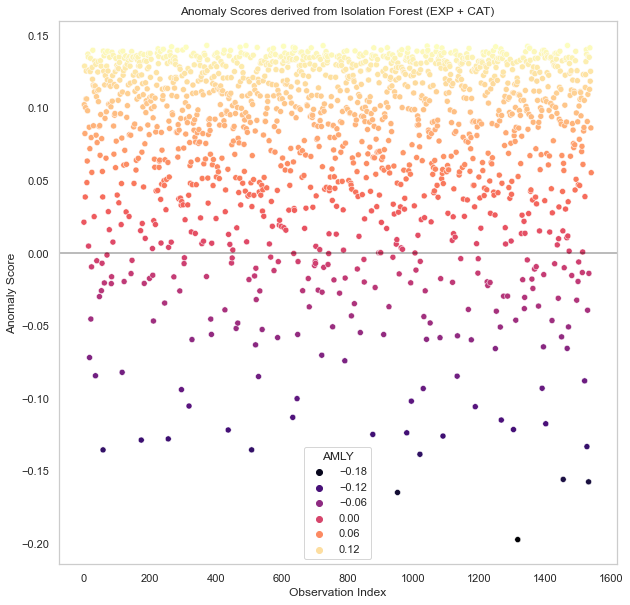

In [391]:
amlyscatter(anomalies = anomalies)

In [381]:
join['AMLY_SCORE'] = anomalies
#SOCIO['AMLY_SCORE'] = anomalies
#EXP['AMLY_SCORE'] = anomalies
#EXP1718['AMLY_SCORE'] = anomalies

In [382]:
join.columns

Index(['REGION31', 'PROBPY42', 'CRFMPY42', 'POVLEV18', 'COGLIM31', 'AFRDPM42',
       'AFRDDN42', 'RXMCD18', 'RXSLF18', 'OPTMCD18', 'OPTSLF18', 'ERTMCD18',
       'ERTSLF18', 'IPTMCD18', 'IPTSLF18', 'DVTMCD18', 'DVTSLF18', 'HHAMCD18',
       'HHNSLF18', 'VISMCD18', 'VISSLF18', 'OTHMCD18', 'OTHSLF18', 'TTLP18X',
       'DFHEAR42', 'DFSEE42', 'ADGENH42_eng', 'AMLY_SCORE'],
      dtype='object')

### Train, Test Split

In [383]:
# Isolate our independent variables from dependent

# Use Socio instead of join? Does it make sense to use the expenditure variables? and Categorical? or both?

#X = EXP.drop(columns=['AMLY_SCORE'])
X = join.drop(columns=['AMLY_SCORE'])
#X = EXP1718.drop(columns=['AMLY_SCORE'])
#X['ADGENH42_eng'] = SOCIO['ADGENH42_eng']
Y = join['AMLY_SCORE']

# Split the training data 

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, shuffle = True, test_size = 0.35)

### Decision Tree Algorithm

In [325]:
# Model naming Schema, DT = Decision Tree, M# = Model Number

DTM1 = DecisionTreeRegressor(max_depth=2) # max depth of 2
DTM1_fit = DTM1.fit(X_train,Y_train)
yhat_M1 = DTM1_fit.predict(X_test)

DTM2 = DecisionTreeRegressor(max_depth=3) # max depth of 2
DTM2_fit = DTM2.fit(X_train,Y_train)
yhat_M2 = DTM2_fit.predict(X_test)

DTM3 = DecisionTreeRegressor(max_depth=50) # max depth of 2
DTM3_fit = DTM3.fit(X_train,Y_train)
yhat_M3 = DTM3_fit.predict(X_test)

### Random Forest Algorithm

In [384]:
RFM1 = RandomForestRegressor(max_depth=2, random_state=0)
RFM1_fit = RFM1.fit(X_train, Y_train)
yhat_RFM1 = RFM1.predict(X_test)

RFM2 = RandomForestRegressor(max_depth=5, random_state=0)
RFM2_fit = RFM2.fit(X_train, Y_train)
yhat_RFM2 = RFM2.predict(X_test)

RFM3 = RandomForestRegressor(max_depth=50, random_state=0)
RFM3_fit = RFM3.fit(X_train, Y_train)
yhat_RFM3 = RFM3.predict(X_test)

###  Render Trees

In [338]:
def rendertree(treeobj = None):
    # Render Decision trees using <https://dreampuf.github.io/GraphvizOnline/>

    graph = tree.export_graphviz(treeobj,
                                 feature_names = X_train.columns.values.tolist(),
                                 label = 'all',
                                 impurity = True,
                                 proportion = True,
                                 rounded = True, 
                                 rotate = True,
                                 out_file='tree.dot',
                                 filled = True)

In [339]:
rendertree(treeobj = RFM3[0])

### Error Metrics

In [385]:
def errormetrics(Yhat = None):    
    print("MSE: ", mean_squared_error(Y_test, Yhat))
    print("MAE: ", median_absolute_error(Y_test, Yhat))
    print("EVS: ", explained_variance_score(Y_test, Yhat))
    print("MaxE: ", max_error(Y_test, Yhat))
    print("R^2: ", r2_score(Y_test, Yhat))

In [386]:
errormetrics(Yhat = yhat_RFM3)

MSE:  0.0006669976876665802
MAE:  0.00752362520602361
EVS:  0.7974500731449266
MaxE:  0.14387104103354514
R^2:  0.7884863788076928


### Feature Importance and P vs. A Charts

In [387]:
def featureimportance(fitalgo = None, algoname = None):
    
    importance = pd.DataFrame({
                              'feature' : X_train.columns.values.tolist(),
                               'importance' : fitalgo.feature_importances_
                              }
                             )\
    .sort_values(
                by='importance',
                 ascending = False
                )\
    .reset_index(drop = True)
    
    sns.barplot(x = "importance",
                y = "feature",
                data = importance,
                palette="Blues_d",
               )
    
    plt.xlabel('Feature Importance')
    plt.title('Feature Importance Chart ' + "(" + algoname + ")")

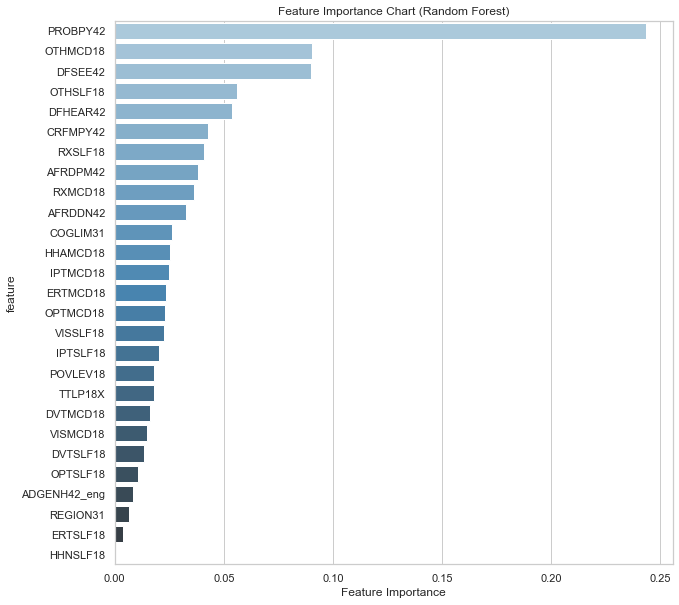

In [388]:
featureimportance(fitalgo = RFM3_fit, algoname = "Random Forest")

In [392]:
# Plot Y_test against Y_hat (bucket)

def pvsa(yhat = None, ytest = None, numbin = None, prec = None, order = True, model = None):
    
    data = pd.DataFrame({'Yhat' : yhat, 'Yactual' : ytest}).reset_index(drop = True)
    data['yhat_bins'] = pd.cut(x = data['Yhat'], bins = numbin, precision = prec, ordered = True)
    
    # Calculate average value for each of the bins
    
    yhat_bin_cnt = data.groupby(['yhat_bins'])['Yhat'].mean().reset_index()
    yhat_bin_cnt['yhat_bins'] = yhat_bin_cnt['yhat_bins'].astype('string')
    yhat_bin_cnt['edge'] = yhat_bin_cnt['yhat_bins'].str.split(r'[(&,]', expand=True)[1]
    yhat_bin_cnt = yhat_bin_cnt.drop(columns=['yhat_bins'])
    yactual_bin_cnt = data.groupby(['yhat_bins'])['Yactual'].mean().reset_index()
    
    # Calculate the total number of observations within that group (histogram)
    
    yhatcnt = data.groupby(['yhat_bins'])['Yhat'].count().reset_index()
    
    yhat_bin_cnt['Yactual'] = yactual_bin_cnt['Yactual']
    yhat_bin_cnt['Yhatcnt'] = yhatcnt['Yhat']
    yhat_bin_cnt = yhat_bin_cnt.fillna(0)
    
    fig, ax = plt.subplots()
    ax.grid(False)
    sns.barplot(data = yhat_bin_cnt,
                x = "edge",
                y = 'Yhatcnt',
                color = "grey",
                alpha = 0.5
               )
    
    ax2 = ax.twinx()
    ax2.grid(False)
    
    sns.lineplot(data = yhat_bin_cnt,
                 x = "edge",
                 y = "Yhat",
                 markers = True,
                 marker = 'o',
                 dashes = True,
                 lw = 3,
                 color = 'r',
                 linestyle = '--',
                 label = 'Predicted'
                )
    
    sns.lineplot(data = yhat_bin_cnt,
                 x = "edge",
                 y = "Yactual",
                 markers = True,
                 lw = 3,
                 marker = 'o',
                 color = 'g',
                 label = "Actual"
                )
    
    plt.axhline(y=0, color = 'black', alpha = 0.25)
    
    ax.set_xlabel("Bucket based of Predicted Value")
    ax.set_ylabel("Count of Observations")
    ax.set_title("Predicted versus Actuals " + model)
    ax2.set_ylabel("Anomaly Score")
    ax.tick_params(axis='x', labelrotation = 45)
    
    return yhat_bin_cnt

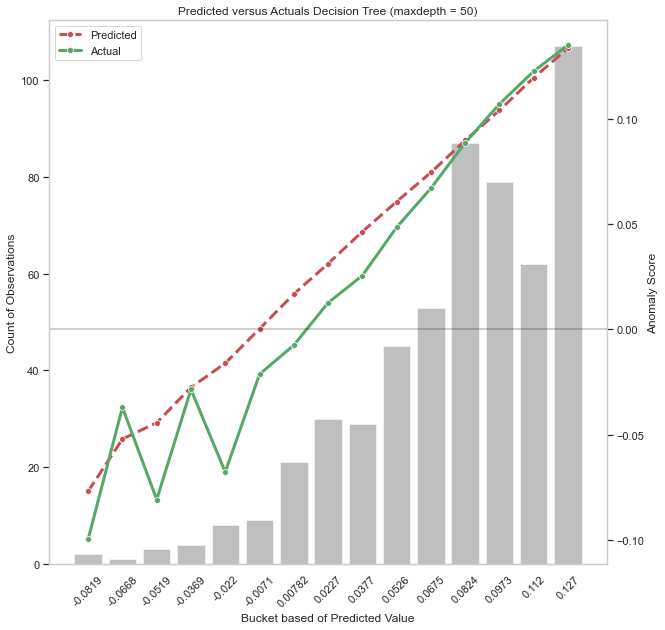

In [395]:
test2 = pvsa(yhat = yhat_RFM3, ytest = Y_test, numbin = 15, prec = 3, model = "Decision Tree (maxdepth = 50)")